In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import concurrent.futures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
data_df = pd.read_csv('structured_data_mac.csv')

# Initialize X (images) and y (labels) lists
X = []
y = []

cnt = 0
# Load and preprocess images
for _, row in data_df.iterrows():
    if(cnt >= 1401):
        break
    image_path = row['Image Path']
    image = nib.load(image_path).get_fdata()
    # print(row['Image Data ID'])

    # Normalize image data
    image = image / np.max(image)

    X.append(image)
    y.append(row['Group'])  # Use the 'Group' column as labels

    print(cnt)
    cnt += 1

# Convert category labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integer category labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)
# print(y_categorical)

# Convert X to a numpy array
X = np.array(X)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
2

In [2]:
# Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2)

split_line = 1199
X_train, y_train = X[:split_line], y_categorical[:split_line]
X_test, y_test = X[split_line:], y_categorical[split_line:]

print(y_train.shape)
print(y_test.shape)

print(y_train[-1])
print(y_test[1])

# X = []

(1199, 3)
(202, 3)
[0. 0. 1.]
[1. 0. 0.]


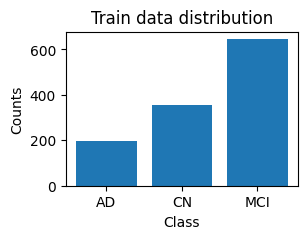

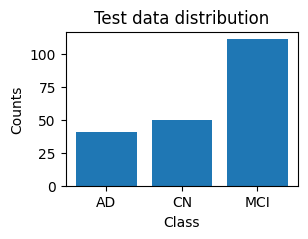

In [3]:
# Plot
# AD - CN - MCI

y_train_counts = np.sum(y_train, axis=0)
num_classes = y_train.shape[1]
class_labels = ['AD', 'CN', 'MCI']
plt.figure(figsize=(3, 2))
plt.bar(class_labels, y_train_counts)
plt.title('Train data distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

y_test_counts = np.sum(y_test, axis=0)
num_classes = y_test.shape[1]
class_labels = ['AD', 'CN', 'MCI']
plt.figure(figsize=(3, 2))
plt.bar(class_labels, y_test_counts)
plt.title('Test data distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

In [4]:
def build_model():
    model = Sequential([
        Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=(96, 96, 96, 1)),
        # Dropout(0.15),
        MaxPooling3D(pool_size=(2, 2, 2)),
        # Dropout(0.1),
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 94, 94, 94, 16)    448       
                                                                 
 max_pooling3d (MaxPooling3  (None, 47, 47, 47, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 45, 45, 45, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 22, 22, 22, 32)    0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 340736)            0         
                                                                 
 dense (Dense)               (None, 16)               

In [5]:
print(X_train.shape)
print(y_train.shape)

split_line = 961
X_val, y_val = X_train[split_line:], y_train[split_line:]
X_train, y_train = X_train[:split_line], y_train[:split_line]

print(y_train[-1])
print(y_val[0])

X = []

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

(1199, 96, 96, 96)
(1199, 3)
[0. 1. 0.]
[0. 0. 1.]
Epoch 1/15


31/31 [==============================] - 44s 1s/step - loss: 2.0077 - accuracy: 0.4922 - val_loss: 1.0367 - val_accuracy: 0.5798
Epoch 2/15
31/31 [==============================] - 35s 1s/step - loss: 0.9932 - accuracy: 0.5286 - val_loss: 1.0030 - val_accuracy: 0.5798
Epoch 3/15
31/31 [==============================] - 35s 1s/step - loss: 0.9467 - accuracy: 0.5286 - val_loss: 1.0152 - val_accuracy: 0.5798
Epoch 4/15
31/31 [==============================] - 35s 1s/step - loss: 0.8811 - accuracy: 0.5713 - val_loss: 1.1021 - val_accuracy: 0.5798
Epoch 5/15
31/31 [==============================] - 34s 1s/step - loss: 0.7577 - accuracy: 0.6629 - val_loss: 1.3892 - val_accuracy: 0.5756
Epoch 6/15
31/31 [==============================] - 35s 1s/step - loss: 0.5782 - accuracy: 0.8106 - val_loss: 1.1741 - val_accuracy: 0.5588
Epoch 7/15
31/31 [==============================] - 34s 1s/step - loss: 1.0318 - accuracy: 0.2341 - val_los

In [6]:
Part_X_test = X_test
Part_y_test = y_test
test_loss, test_acc = model.evaluate(Part_X_test, Part_y_test)
print(f"Test Accuracy: {test_acc}")

7/7 [==============================] - 2s 296ms/step - loss: 1.0393 - accuracy: 0.5495
Test Accuracy: 0.5495049357414246


In [7]:
# train_probabilities = model.predict(X_train)
# test_probabilities = model.predict(X_test)

# print("Train Probabilities Shape:", train_probabilities.shape)
# print("Test Probabilities Shape:", test_probabilities.shape)

In [8]:
# print("Train Probabilities:", train_probabilities)
# for i, j in zip(test_probabilities, y_test):
#     print("Test Probabilities:", i, "True value:", j)

In [9]:
# Initialize X (images) and y (labels) lists
X = []
y = []

cnt = 0

# Load and preprocess images
for _, row in data_df.iterrows():
    if(cnt >= 2802):
        break
    if(cnt >= 1595):
        image_path = row['Image Path']
        image = nib.load(image_path).get_fdata()

        # Normalize image data
        image = image / np.max(image)

        X.append(image)
        y.append(row['Group'])  # Use the 'Group' column as labels

    print(cnt)
    cnt += 1

# Convert category labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integer category labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)
# print(y_categorical)

# Convert X to a numpy array
X = np.array(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
# Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2)

split_line = 1008
X_train, y_train = X[:split_line], y_categorical[:split_line]
X_test_2, y_test_2 = X[split_line:], y_categorical[split_line:]

print(y_train.shape)
print(y_test_2.shape)

print(y_train[-1])
print(y_test_2[1])

# X = []

(1008, 3)
(199, 3)
[0. 0. 1.]
[0. 1. 0.]


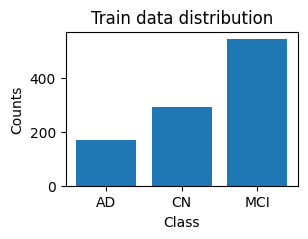

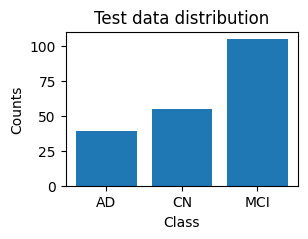

In [11]:
# Plot
# AD - CN - MCI

y_train_counts = np.sum(y_train, axis=0)
num_classes = y_train.shape[1]
class_labels = ['AD', 'CN', 'MCI']
plt.figure(figsize=(3, 2))
plt.bar(class_labels, y_train_counts)
plt.title('Train data distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

y_test_2_counts = np.sum(y_test_2, axis=0)
num_classes = y_test_2.shape[1]
class_labels = ['AD', 'CN', 'MCI']
plt.figure(figsize=(3, 2))
plt.bar(class_labels, y_test_2_counts)
plt.title('Test data distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

In [12]:
model_2 = build_model()
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 94, 94, 94, 16)    448       
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 47, 47, 47, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 45, 45, 45, 32)    13856     
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 22, 22, 22, 32)    0         
 g3D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 340736)            0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [13]:
print(X_train.shape)
print(y_train.shape)

split_line = 800
X_val, y_val = X_train[split_line:], y_train[split_line:]
X_train, y_train = X_train[:split_line], y_train[:split_line]

print(y_train[-1])
print(y_val[0])

X = []

history = model_2.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))

(1008, 96, 96, 96)
(1008, 3)
[0. 0. 1.]
[0. 1. 0.]
Epoch 1/15
25/25 [==============================] - 41s 1s/step - loss: 1.4670 - accuracy: 0.5275 - val_loss: 1.0763 - val_accuracy: 0.4663
Epoch 2/15
25/25 [==============================] - 29s 1s/step - loss: 0.9188 - accuracy: 0.5813 - val_loss: 1.1635 - val_accuracy: 0.3942
Epoch 3/15
25/25 [==============================] - 28s 1s/step - loss: 0.7534 - accuracy: 0.6525 - val_loss: 1.3984 - val_accuracy: 0.4760
Epoch 4/15
25/25 [==============================] - 29s 1s/step - loss: 0.5528 - accuracy: 0.7437 - val_loss: 1.3453 - val_accuracy: 0.4471
Epoch 5/15
25/25 [==============================] - 29s 1s/step - loss: 0.3273 - accuracy: 0.8188 - val_loss: 1.2640 - val_accuracy: 0.4567
Epoch 6/15
25/25 [==============================] - 29s 1s/step - loss: 0.1958 - accuracy: 0.9075 - val_loss: 1.8364 - val_accuracy: 0.4423
Epoch 7/15
25/25 [==============================] - 29s 1s/step - loss: 0.1007 - accuracy: 0.9887 - val_loss:

In [14]:
Part_X_test = X_test
Part_y_test = y_test
test_loss, test_acc = model.evaluate(Part_X_test, Part_y_test)
Part_X_test_2 = X_test_2
Part_y_test_2 = y_test_2
test_loss_2, test_acc_2 = model.evaluate(Part_X_test_2, Part_y_test_2)
Part_X_test_3 = X_test
Part_y_test_3 = y_test
test_loss_3, test_acc_3 = model_2.evaluate(Part_X_test_3, Part_y_test_3)
Part_X_test_4 = X_test_2
Part_y_test_4 = y_test_2
test_loss_4, test_acc_4 = model_2.evaluate(Part_X_test_4, Part_y_test_4)
print("Test case1 (model 1):")
print(f"Test Accuracy: {test_acc}")
print("Test case1 (model 2):")
print(f"Test Accuracy: {test_acc_3}")
print("Test case2 (model 1):")
print(f"Test Accuracy: {test_acc_2}")
print("Test case2 (model 2):")
print(f"Test Accuracy: {test_acc_4}")

7/7 [==============================] - 2s 273ms/step - loss: 2.0241 - accuracy: 0.5578
Test case1 (model 1):
Test Accuracy: 0.5495049357414246
Test case1 (model 2):
Test Accuracy: 0.594059407711029
Test case2 (model 1):
Test Accuracy: 0.5276381969451904
Test case2 (model 2):
Test Accuracy: 0.5577889680862427


In [15]:
test_probabilities = model.predict(X_test)
test_probabilities_2 = model_2.predict(X_test)
test_probabilities_3 = model.predict(X_test_2)
test_probabilities_4 = model_2.predict(X_test_2)

new_probabilities = test_probabilities + test_probabilities_2
new_probabilities_2 = test_probabilities_3 + test_probabilities_4

predicted_classes_1 = np.argmax(new_probabilities, axis=1)
true_classes_1 = np.argmax(y_test, axis=1)
accuracy_1 = np.mean(predicted_classes_1 == true_classes_1)
print("Test case1 (model mix)")
print("Accuracy:", accuracy_1)

predicted_classes_2 = np.argmax(new_probabilities_2, axis=1)
true_classes_2 = np.argmax(y_test_2, axis=1)
accuracy_2 = np.mean(predicted_classes_2 == true_classes_2)
print("Test case2 (model mix)")
print("Accuracy:", accuracy_2)

7/7 [==============================] - 2s 283ms/step
Test case1 (model mix)
Accuracy: 0.5841584158415841
Test case2 (model mix)
Accuracy: 0.5477386934673367


In [16]:
# # Initialize X (images) and y (labels) lists
# X = []
# y = []

# cnt = 0

# # Load and preprocess images
# for _, row in data_df.iterrows():
#     if(cnt >= 3180):
#         break
#     if(cnt >= 2802):
#         image_path = row['Image Path']
#         image = nib.load(image_path).get_fdata()

#         # Normalize image data
#         image = image / np.max(image)

#         X.append(image)
#         y.append(row['Group'])  # Use the 'Group' column as labels

#     print(cnt)
#     cnt += 1

# # Convert category labels to integers
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Convert integer category labels to one-hot encoding
# num_classes = len(label_encoder.classes_)
# y_categorical = to_categorical(y_encoded, num_classes=num_classes)
# # print(y_categorical)

# # Convert X to a numpy array
# X = np.array(X)

In [17]:
# X_test_3, y_test_3 = X[:], y_categorical[:]

# print(y_test_3.shape)

# # Plot
# # AD - CN - MCI

# y_test_3_counts = np.sum(y_test_3, axis=0)
# num_classes = y_test_3.shape[1]
# class_labels = ['AD', 'CN', 'MCI']
# plt.figure(figsize=(3, 2))
# plt.bar(class_labels, y_test_3_counts)
# plt.title('Train data distribution')
# plt.xlabel('Class')
# plt.ylabel('Counts')
# plt.show()

# X = []

In [18]:
# Part_X_test_5 = X_test_3
# Part_y_test_5 = y_test_3
# test_loss, test_acc_5 = model.evaluate(Part_X_test_5, Part_y_test_5)
# Part_X_test_6 = X_test_3
# Part_y_test_6 = y_test_3
# test_loss, test_acc_6 = model_2.evaluate(Part_X_test_6, Part_y_test_6)

# print("Test case3 (model 1):")
# print(f"Test Accuracy: {test_acc_5}")
# print("Test case3 (model 2):")
# print(f"Test Accuracy: {test_acc_6}")

In [19]:
# test_probabilities_5 = model.predict(X_test_3)
# test_probabilities_6 = model_2.predict(X_test_3)

# new_probabilities_3 = test_probabilities_5 + test_probabilities_6

# predicted_classes_3 = np.argmax(new_probabilities_3, axis=1)
# true_classes_3 = np.argmax(y_test_3, axis=1)
# accuracy_3 = np.mean(predicted_classes_3 == true_classes_3)
# print("Test case3 (model mix)")
# print("Accuracy:", accuracy_3)

In [20]:
X = []
y = []

In [1]:
# Load the CSV file
data_df_2 = pd.read_csv('dataB_change.csv')

# Initialize X (images) and y (labels) lists
del y_categorical
del y_encoded
del X
del y
X = []
y = []
invalid_ID = ['I306344', 'I425259', 'I319979', 'I321488', 'I376845', 'I335055']

cnt = 0
# Load and preprocess images
for _, row in data_df_2.iterrows():

    if row[0] in invalid_ID: continue

    if row['Description'] != 'MPRAGE': continue

    if(cnt >= 280):
        break
    image_path = 'DataB/dataB/' + row['Image Data ID'] + '.nii'
    image = nib.load(image_path).get_fdata()
    # print(row['Image Data ID'])
    image = np.resize(image, (96, 96, 96))

    # Normalize image data
    # image = image / np.max(image)

    X.append(image)
    if row['Group'] == "EMCI" or row['Group'] == 'MCI' or row['Group'] == 'LMCI':
        y.append('MCI')  # Use the 'Group' column as labels
    else:
        y.append(row['Group'])  # Use the 'Group' column as labels

    print(cnt)
    cnt += 1

# Convert category labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integer category labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)
# print(y_categorical)

X = np.array(X)


NameError: name 'pd' is not defined

In [ ]:
X_test, y_test = X[:], y_categorical[:]

In [ ]:
# Assuming X is already defined

# Convert X to a numpy array
# X = np.array(X)

shape_set = {}
for i in range(280):
    # X[i] = np.resize(X[i], (96, 96, 96))
    shape = X[i].shape
    if shape not in shape_set:
        shape_set[shape] = 1
    else:
        shape_set[shape] += 1

print(shape_set)
print(len(shape_set))

{(96, 96, 96): 280}
1


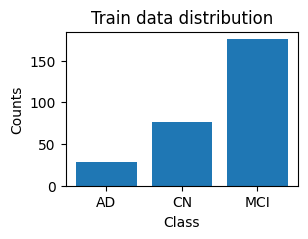

In [ ]:
# Plot
# AD - CN - MCI

y_test_3_counts = np.sum(y_test, axis=0)
num_classes = y_test.shape[1]
class_labels = ['AD', 'CN', 'MCI']
plt.figure(figsize=(3, 2))
plt.bar(class_labels, y_test_3_counts)
plt.title('Train data distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

X = []

In [ ]:
# print(X.shape)
# print(y_categorical.shape)

In [ ]:
Part_X_test_5 = X_test
Part_y_test_5 = y_test
test_loss, test_acc_5 = model.evaluate(Part_X_test_5, Part_y_test_5)
Part_X_test_6 = X_test
Part_y_test_6 = y_test
test_loss, test_acc_6 = model_2.evaluate(Part_X_test_6, Part_y_test_6)

print("Test case3 (model 1):")
print(f"Test Accuracy: {test_acc_5}")
print("Test case3 (model 2):")
print(f"Test Accuracy: {test_acc_6}")

9/9 [==============================] - 3s 304ms/step - loss: 0.9712 - accuracy: 0.6286
Test case3 (model 1):
Test Accuracy: 0.5178571343421936
Test case3 (model 2):
Test Accuracy: 0.6285714507102966


In [ ]:
test_probabilities_5 = model.predict(X_test)
test_probabilities_6 = model_2.predict(X_test)

new_probabilities_3 = test_probabilities_5 + test_probabilities_6

predicted_classes_3 = np.argmax(new_probabilities_3, axis=1)
true_classes_3 = np.argmax(y_test, axis=1)
accuracy_3 = np.mean(predicted_classes_3 == true_classes_3)
print("Test case3 (model mix)")
print("Accuracy:", accuracy_3)

9/9 [==============================] - 3s 308ms/step
Test case3 (model mix)
Accuracy: 0.5178571428571429
